<a href="https://colab.research.google.com/github/HaqTetsuya/rusdi-prototype-1/blob/greeting_test/rusdi_prototype_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Teks judul default
# Cell 1: Instalasi library yang diperlukan
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm

In [ ]:
# prompt: buat kode untuk request dari github HaqTetsuya/rusdi-prototype-1 namun di branch greeting_test dan download semua kode

!git clone -b greeting_test https://github.com/HaqTetsuya/rusdi-prototype-1.git




Cloning into 'rusdi-prototype-1'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 337 (delta 157), reused 316 (delta 140), pack-reused 0 (from 0)
Receiving objects: 100% (337/337), 770.80 KiB | 8.76 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [4]:
# @title Cell 2: Import library yang diperlukan
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from google.colab import drive, files

In [5]:
# @title Cell 3: Mount Google Drive untuk menyimpan model dan data
# Uncomment ini jika ingin menggunakan Google Drive

drive.mount('/content/drive')
MODEL_SAVE_PATH = "/content/drive/MyDrive/indobert_intent_model2"



# Cell 4: Kelas Dataset untuk IndoBERT
class IntentDataset(Dataset):
    """Dataset untuk klasifikasi intent dengan IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)

        return item



Mounted at /content/drive


In [ ]:
# @title Cell 5: Fungsi untuk membuat contoh file CSV
def create_sample_csv(output_file="sample_intent_data.csv"):
    """Membuat contoh file CSV dengan data intent untuk demonstrasi"""

    data = {
        'text': [
            "Bagaimana cara meminjam buku di perpustakaan?",
            "Apa jam buka perpustakaan hari ini?",
            "Berapa lama masa peminjaman buku?",
            "Saya ingin memperpanjang peminjaman buku",
            "Bagaimana cara menjadi anggota perpustakaan?",
            "Berapa denda untuk keterlambatan pengembalian?",
            "Apakah perpustakaan mempunyai ruang belajar?",
            "Bagaimana cara mencari buku tentang sejarah Indonesia?",
            "Apakah perpustakaan memiliki layanan e-book?",
            "Saya kehilangan kartu anggota perpustakaan",
            "Bagaimana cara mengakses jurnal ilmiah?",
            "Dimana letak koleksi buku referensi?",
            "Apakah ada acara diskusi buku minggu ini?",
            "Berapa buku maksimal yang bisa dipinjam?",
            "Saya ingin memesan buku yang sedang dipinjam",
            "Apakah ada WiFi gratis di perpustakaan?",
            "Berapa biaya fotokopi dokumen di perpustakaan?",
            "Saya ingin mendonasikan buku ke perpustakaan",
            "Bagaimana cara menggunakan komputer di perpustakaan?",
            "Apakah perpustakaan punya koleksi tesis dan disertasi?",
            "Saya ingin mengajukan permintaan buku baru",
            "Bisakah saya meminjam buku antar-perpustakaan?",
            "Apa syarat menjadi anggota perpustakaan?",
            "Bagaimana cara mencari artikel jurnal?",
            "Apakah ada fasilitas printer di perpustakaan?",
            "Berapa lama waktu operasional perpustakaan?",
            "Saya ingin melaporkan kerusakan buku",
            "Bagaimana proses pengembalian buku?",
            "Apakah layanan peminjaman tersedia online?",
            "Dimana saya bisa menemukan kamus bahasa asing?"
        ],
        'intent': [
            "peminjaman_buku",
            "jam_operasional",
            "masa_peminjaman",
            "perpanjangan",
            "pendaftaran_anggota",
            "denda",
            "fasilitas",
            "pencarian_buku",
            "layanan_digital",
            "kehilangan_kartu",
            "akses_jurnal",
            "lokasi_koleksi",
            "agenda_perpustakaan",
            "kuota_peminjaman",
            "reservasi_buku",
            "fasilitas",
            "biaya_layanan",
            "donasi_buku",
            "penggunaan_fasilitas",
            "koleksi_khusus",
            "permintaan_buku",
            "peminjaman_antar_perpustakaan",
            "pendaftaran_anggota",
            "pencarian_jurnal",
            "fasilitas",
            "jam_operasional",
            "laporan_masalah",
            "pengembalian_buku",
            "layanan_online",
            "lokasi_koleksi"
        ]
    }

    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)
    print(f"File contoh CSV berhasil dibuat: {output_file}")
    return output_file


In [6]:

# @title Cell 6: Fungsi untuk memuat data dari CSV
def load_data_from_csv(csv_path):
    """Memuat data intent dari file CSV"""
    print(f"Memuat data dari: {csv_path}")

    # Cek apakah file ada
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File CSV tidak ditemukan: {csv_path}")

    # Memuat data
    try:
        df = pd.read_csv(csv_path)
        print(f"Berhasil memuat {len(df)} baris data")
    except Exception as e:
        raise Exception(f"Error saat memuat file CSV: {str(e)}")

    # Cek kolom yang diperlukan
    required_columns = ['text', 'intent']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Kolom '{col}' tidak ditemukan dalam file CSV")

    # Mengonversi label intent menjadi angka
    label_encoder = LabelEncoder()
    df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

    # Informasi tentang intent yang ditemukan
    intent_classes = label_encoder.classes_
    num_labels = len(intent_classes)
    print(f"Ditemukan {num_labels} intent berbeda dalam dataset")

    # Tampilkan distribusi intent
    intent_counts = df['intent'].value_counts()
    print("\nDistribusi intent:")
    for intent, count in intent_counts.items():
        print(f"  {intent}: {count} contoh")

    # Membagi data menjadi training dan validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['intent'])

    print(f"Data dibagi menjadi {len(train_df)} sampel training dan {len(val_df)} sampel validasi")

    # Menyiapkan data untuk pelatihan
    train_texts = train_df['text'].values
    train_labels = train_df['intent_encoded'].values
    val_texts = val_df['text'].values
    val_labels = val_df['intent_encoded'].values

    return train_texts, val_texts, train_labels, val_labels, intent_classes, num_labels, label_encoder


In [7]:
# @title Cell 7: Fungsi untuk setup model IndoBERT
def setup_indobert_for_intent(num_labels):
    """Load model IndoBERT untuk klasifikasi intent"""

    print("Memuat model IndoBERT...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p1",
        num_labels=num_labels
    )
    print("Model berhasil dimuat")

    return model, tokenizer

In [8]:
# @title OOD
def calibrate_ood_detection(model, tokenizer, dataloader, temperature=1.0, percentile=95):
    """
    Kalibrasi threshold untuk OOD detection menggunakan data in-distribution
    """
    device = next(model.parameters()).device
    model.eval()

    # Untuk Energy method
    energy_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Kalibrasi OOD detection"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits

            # Energy score
            energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
            energy_scores.extend(energy.cpu().numpy())

    # Hitung threshold untuk Energy (maksimal energy untuk in-distribution)
    energy_threshold = np.percentile(energy_scores, percentile)

    return energy_threshold

In [9]:
# @title cell 8: fungsi training
import os
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import get_scheduler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                           batch_size=16, epochs=10, learning_rate=2e-5, weight_decay=0.01,
                           save_path=MODEL_SAVE_PATH, use_class_weights=True, patience=3):
    """
    Melatih model IndoBERT untuk klasifikasi intent dengan perbaikan:
    - Early stopping
    - Weight decay untuk regularisasi
    - Class weights untuk mengatasi imbalance
    - Monitoring metrics yang lebih komprehensif (loss, accuracy, F1, precision, recall)
    - Learning rate scheduler yang lebih sophisticated
    """

    # Persiapkan dataset
    print("Menyiapkan dataset...")
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Compute class weights if needed
    if use_class_weights:
        # Get unique classes
        unique_classes = np.unique(train_labels)
        # Compute weights
        weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=train_labels
        )
        # Convert to tensor
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        class_weights = torch.FloatTensor(weights).to(device)
        print(f"Menggunakan class weights: {weights}")
    else:
        class_weights = None

    # Optimizer dengan weight decay untuk regularisasi
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler dengan warmup
    num_training_steps = len(train_dataloader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_training_steps)

    # Cek untuk GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")
    model.to(device)
    print(f"Mulai pelatihan model...")
    print(f"Total epoch: {epochs}, batch size: {batch_size}, learning rate: {learning_rate}, weight decay: {weight_decay}")

    # Create loss function with class weights if needed
    if class_weights is not None:
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
        loss_fn = torch.nn.CrossEntropyLoss()

    # Logging training
    best_val_loss = float('inf')
    counter = 0  # Counter for early stopping
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        tqdm.write(f"\nEpoch {epoch+1}/{epochs} - Training dimulai...")
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for batch in progress_bar:
            try:
                # Pindahkan batch ke device
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                # Forward pass with custom loss function
                optimizer.zero_grad()

                # Modified to use our loss function instead of the model's default
                outputs = model(**inputs)
                logits = outputs.logits
                loss = loss_fn(logits, labels)

                # Backward pass
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

            except RuntimeError as e:
                if "out of memory" in str(e):
                    tqdm.write("Peringatan: Kehabisan memori! Membersihkan cache...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        tqdm.write(f"Epoch {epoch+1}/{epochs} - Validasi dimulai...")
        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                # Hitung akurasi
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

                # Collect predictions and labels for metrics
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        # Calculate metrics
        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Save metrics to history
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(accuracy)
        history['val_f1'].append(f1)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)

        # Print detailed metrics
        tqdm.write(f"Epoch {epoch+1}/{epochs}:")
        tqdm.write(f"  Train Loss: {avg_train_loss:.4f}")
        tqdm.write(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy*100:.2f}%")
        tqdm.write(f"  Val F1: {f1:.4f}, Val Precision: {precision:.4f}, Val Recall: {recall:.4f}")

        # Early stopping and model saving logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0  # Reset early stopping counter

            if not os.path.exists(save_path):
                os.makedirs(save_path)

            tqdm.write(f"Menyimpan model terbaik ke {save_path}")
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

            # Save classification report for best model
            report = classification_report(all_labels, all_preds, output_dict=True)
            with open(os.path.join(save_path, "classification_report.json"), 'w') as f:
                json.dump(report, f, indent=4)
        else:
            counter += 1
            tqdm.write(f"Validation loss tidak membaik. Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                tqdm.write(f"Early stopping triggered setelah {epoch+1} epochs")
                break

    tqdm.write(f"Pelatihan selesai! Model terbaik disimpan di {save_path}")

    # Simpan history ke file JSON
    history_file = os.path.join(save_path, "training_history.json")
    with open(history_file, 'w') as f:
        json.dump(history, f)
    tqdm.write(f"History training disimpan di {history_file}")

    # Plot hasil training
    plot_training_results(history, save_path)

    # Kalibrasi threshold untuk OOD detection
    print("Kalibrasi threshold untuk OOD detection...")
    energy_threshold = calibrate_ood_detection(model, tokenizer, val_dataloader)
    print(f"Energy threshold: {energy_threshold:.4f}")

    # Save threshold
    threshold_file = os.path.join(save_path, "ood_threshold.json")
    with open(threshold_file, 'w') as f:
        json.dump({"energy_threshold": float(energy_threshold)}, f)
    print(f"OOD threshold disimpan di {threshold_file}")

    return model, history

def plot_training_results(history, save_path):
    """Plot dan simpan hasil training metrics"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1', marker='o', color='purple')
    plt.title('F1 Score selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: Precision & Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['val_precision'], label='Validation Precision', marker='o', color='orange')
    plt.plot(history['val_recall'], label='Validation Recall', marker='o', color='brown')
    plt.title('Precision & Recall selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, "training_metrics.png"))
    plt.show()

In [10]:
# @title Cell 9: Fungsi untuk evaluasi model
def evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes, batch_size=16):
    """Evaluasi model dan tampilkan confusion matrix dan metrics"""

    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluasi"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=intent_classes, digits=4)
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=intent_classes, yticklabels=intent_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return report, cm


In [11]:
def predict_intent_with_ood(text, model, tokenizer, intent_classes, energy_threshold,
                          temperature=1.0, label_encoder=None, device=None):
    """Memprediksi intent dari teks input dengan deteksi Out-of-Distribution"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Hitung energy score: -T*log(sum(exp(logits/T)))
        energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
        energy_score = energy.item()

        # Hitung juga confidence biasa
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    # Periksa apakah input adalah OOD berdasarkan energy score
    is_ood = energy_score > energy_threshold

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    result = {
        "intent": "out_of_distribution" if is_ood else intent_classes[prediction],
        "confidence": confidence,
        "energy_score": energy_score,
        "is_ood": is_ood,
        "top_intents": topk_intents
    }

    return result

In [12]:
# @title Cell 11: Fungsi untuk latih
import os
import pickle

def run_full_pipeline(use_drive=True):
    """Jalankan pipeline lengkap: buat contoh, latih model, evaluasi"""

    # Buat folder jika belum ada
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    # 1. Buat atau muat dataset
    csv_file = "sample_intent_data.csv"
    if not os.path.exists(csv_file):
        csv_file = create_sample_csv(csv_file)

    # 2. Muat data
    train_texts, val_texts, train_labels, val_labels, intent_classes, num_labels, label_encoder = load_data_from_csv(csv_file)

    # 3. Setup model
    model, tokenizer = setup_indobert_for_intent(num_labels)

    # 4. Latih model
    model, history = train_intent_classifier(
        model,
        tokenizer,
        train_texts,
        train_labels,
        val_texts,
        val_labels,
        batch_size=16,
        epochs=10,  # Increased epochs with early stopping
        learning_rate=2e-5,  # Reduced learning rate
        weight_decay=0.01,  # Added regularization
        patience=3  # Early stopping after 3 epochs without improvement
    )

    # 5. Evaluasi model
    report, cm = evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes)

    # 6. Simpan intent classes & label encoder
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print(f"\n✅ Model telah berhasil dilatih dan disimpan di {MODEL_SAVE_PATH}")
    print(f"Jumlah intent: {num_labels}")
    print(f"Intent yang didukung: {', '.join(intent_classes)}")

    return model, tokenizer, intent_classes, label_encoder


In [16]:
# @title Cell 12: Fungsi untuk demo prediksi dengan OOD detection
def run_prediction_demo(model=None, tokenizer=None, intent_classes=None, label_encoder=None):
    """Jalankan demo prediksi intent dengan model yang telah dilatih dan OOD detection"""

    # Jika model tidak diberikan, muat dari path penyimpanan
    if model is None or tokenizer is None or intent_classes is None:
        if not os.path.exists(MODEL_SAVE_PATH):
            print(f"Error: Model tidak ditemukan di {MODEL_SAVE_PATH}")
            print("Jalankan run_full_pipeline() terlebih dahulu untuk melatih model")
            return

        # Muat model dan tokenizer
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)

        # Muat intent classes
        import pickle
        with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "rb") as f:
            intent_classes = pickle.load(f)

        # Load OOD threshold
    try:
        with open(os.path.join(MODEL_SAVE_PATH, "ood_threshold.json"), 'r') as f:
          threshold_data = json.load(f)
          energy_threshold = threshold_data["energy_threshold"]
        print(f"OOD threshold loaded: {energy_threshold:.4f}")
    except FileNotFoundError:
        print("Warning: OOD threshold file not found. Using default threshold.")
        energy_threshold = 0.0  # Default fallback value

    # Contoh pertanyaan untuk demo
    test_texts = [
        # GREETING Variations
        "Halo!",
        # GOODBYE Variations
        "Oke, sampai jumpa!",
        # CONFIRM Variations
        "Ya, benar begitu.",
        # DENIED Variations
        "Tidak, saya tidak setuju.",
        # GREETING Confusers
        "Halo, saya ingin memesan tiket ke Bali.",
        # GOODBYE Confusers
        "Sampai jumpa... Eh, tunggu sebentar, ada yang ingin saya tanyakan!",
        # CONFIRM Confusers
        "Ya, saya setuju, tapi ada satu hal yang perlu ditanyakan.",
        # DENIED Confusers
        "Tidak, saya tidak setuju... kecuali kalau ada diskon!",  # Penolakan bersyarat
        # OOD examples
        "Saya ingin membahas tentang cara membuat kue brownies yang enak",
        "Berapa lama waktu yang dibutuhkan pesawat untuk terbang dari Jakarta ke New York?"
    ]

    print("Demo Prediksi Intent dengan OOD Detection:")

    # Prediksi dari contoh
    for text in test_texts:
        result = predict_intent_with_ood(text, model, tokenizer, intent_classes, energy_threshold)

        print(f"\nInput: \"{text}\"")
        if result["is_ood"]:
            print(f"⚠️ Terdeteksi sebagai Out-of-Distribution (Energy: {result['energy_score']:.4f})")
            print("Sistem tidak yakin dengan maksud Anda. Bisa tolong dijelaskan lagi?")
        else:
            print(f"Intent terdeteksi: {result['intent']} (confidence: {result['confidence']:.4f})")

        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(result["top_intents"]):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

    # Prediksi input pengguna
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        result = predict_intent_with_ood(user_input, model, tokenizer, intent_classes, energy_threshold)

        if result["is_ood"]:
            print(f"⚠️ Terdeteksi sebagai Out-of-Distribution (Energy: {result['energy_score']:.4f})")

        else:
            print(f"Intent terdeteksi: {result['intent']} (confidence: {result['confidence']:.4f})")

        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(result["top_intents"]):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

Memuat data dari: sample_intent_data.csv
Berhasil memuat 2301 baris data
Ditemukan 4 intent berbeda dalam dataset

Distribusi intent:
  goodbye: 612 contoh
  denied: 581 contoh
  greeting: 559 contoh
  confirm: 549 contoh
Data dibagi menjadi 1840 sampel training dan 461 sampel validasi
Memuat model IndoBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model berhasil dimuat
Menyiapkan dataset...
Menggunakan class weights: [1.04783599 0.98924731 0.9406953  1.02908277]
Menggunakan device: cuda
Mulai pelatihan model...
Total epoch: 10, batch size: 16, learning rate: 2e-05, weight decay: 0.01

Epoch 1/10 - Training dimulai...


Epoch 1/10 [Training]:   0%|          | 0/115 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1/10 - Validasi dimulai...


Epoch 1/10:
  Train Loss: 0.9601
  Val Loss: 0.4482, Val Accuracy: 82.86%
  Val F1: 0.8312, Val Precision: 0.8501, Val Recall: 0.8286
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model2

Epoch 2/10 - Training dimulai...


Epoch 2/10 - Validasi dimulai...


Epoch 2/10:
  Train Loss: 0.3353
  Val Loss: 0.2462, Val Accuracy: 92.41%
  Val F1: 0.9240, Val Precision: 0.9272, Val Recall: 0.9241
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model2

Epoch 3/10 - Training dimulai...


Epoch 3/10 - Validasi dimulai...


Epoch 3/10:
  Train Loss: 0.1438
  Val Loss: 0.2461, Val Accuracy: 92.84%
  Val F1: 0.9287, Val Precision: 0.9316, Val Recall: 0.9284
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model2

Epoch 4/10 - Training dimulai...


Epoch 4/10 - Validasi dimulai...


Epoch 4/10:
  Train Loss: 0.0710
  Val Loss: 0.3335, Val Accuracy: 92.62%
  Val F1: 0.9263, Val Precision: 0.9279, Val Recall: 0.9262
Validation loss tidak membaik. Early stopping counter: 1/3

Epoch 5/10 - Training dimulai...


Epoch 5/10 - Validasi dimulai...


Epoch 5/10:
  Train Loss: 0.0511
  Val Loss: 0.2792, Val Accuracy: 94.79%
  Val F1: 0.9481, Val Precision: 0.9487, Val Recall: 0.9479
Validation loss tidak membaik. Early stopping counter: 2/3

Epoch 6/10 - Training dimulai...


Epoch 6/10 - Validasi dimulai...


Epoch 6/10:
  Train Loss: 0.0387
  Val Loss: 0.2952, Val Accuracy: 94.14%
  Val F1: 0.9416, Val Precision: 0.9425, Val Recall: 0.9414
Validation loss tidak membaik. Early stopping counter: 3/3
Early stopping triggered setelah 6 epochs
Pelatihan selesai! Model terbaik disimpan di /content/drive/MyDrive/indobert_intent_model2
History training disimpan di /content/drive/MyDrive/indobert_intent_model2/training_history.json


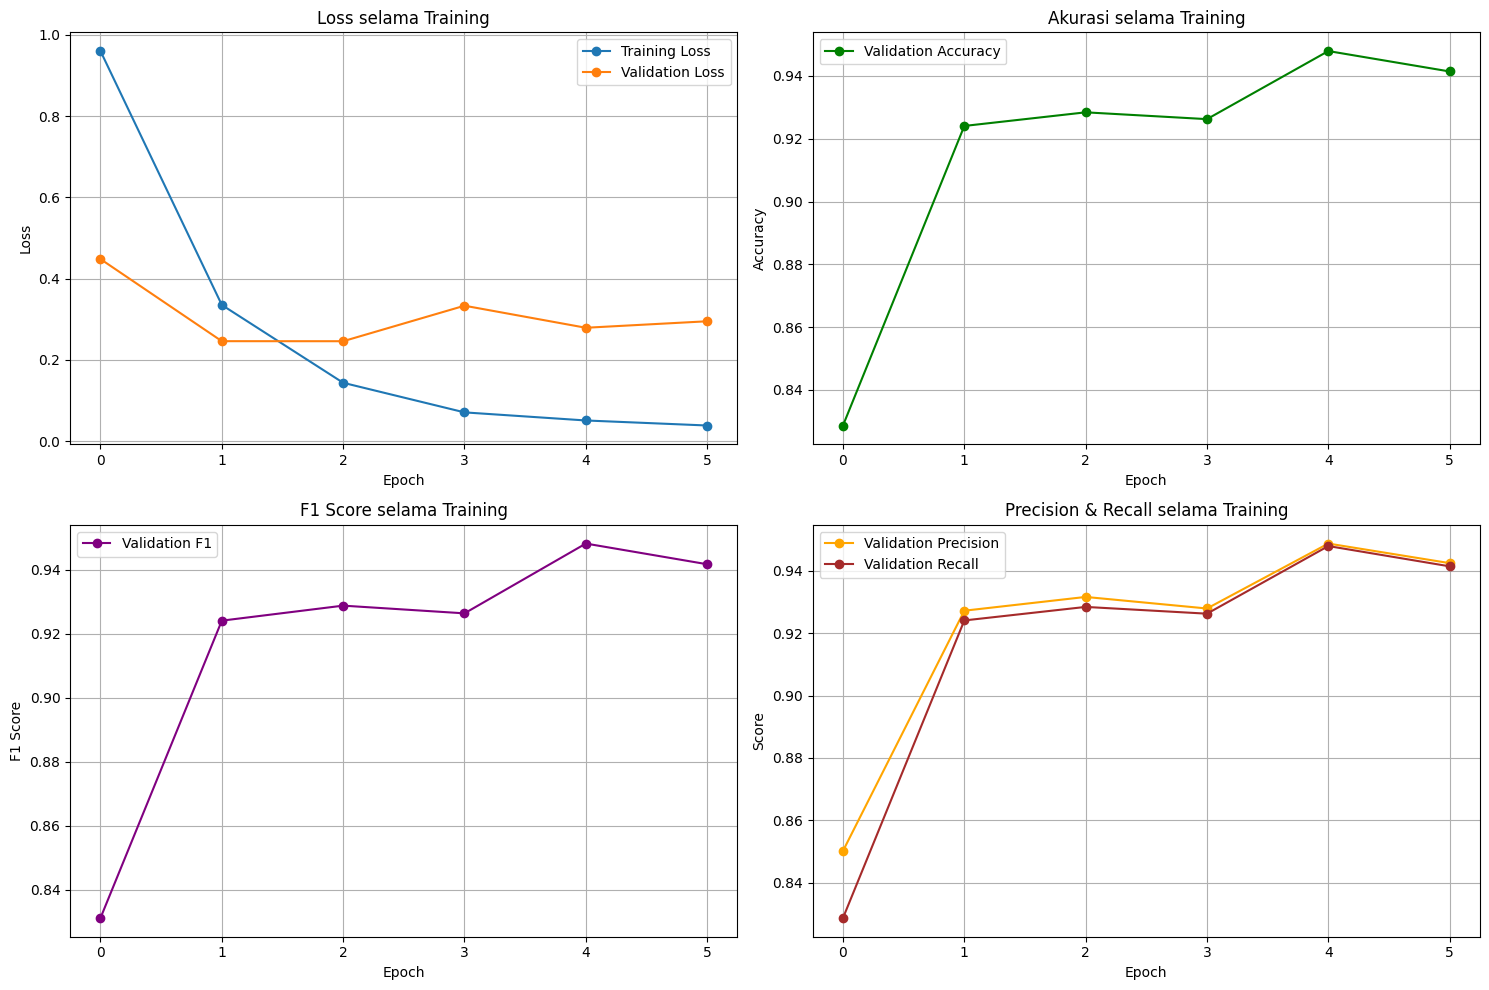

Kalibrasi threshold untuk OOD detection...


Kalibrasi OOD detection: 100%|██████████| 29/29 [00:03<00:00,  8.93it/s]


Energy threshold: -4.0359
OOD threshold disimpan di /content/drive/MyDrive/indobert_intent_model2/ood_threshold.json


Evaluasi: 100%|██████████| 29/29 [00:03<00:00,  9.09it/s]


Classification Report:
              precision    recall  f1-score   support

     confirm     0.9204    0.9455    0.9327       110
      denied     0.9407    0.9569    0.9487       116
     goodbye     0.9914    0.9350    0.9623       123
    greeting     0.9123    0.9286    0.9204       112

    accuracy                         0.9414       461
   macro avg     0.9412    0.9415    0.9410       461
weighted avg     0.9425    0.9414    0.9416       461



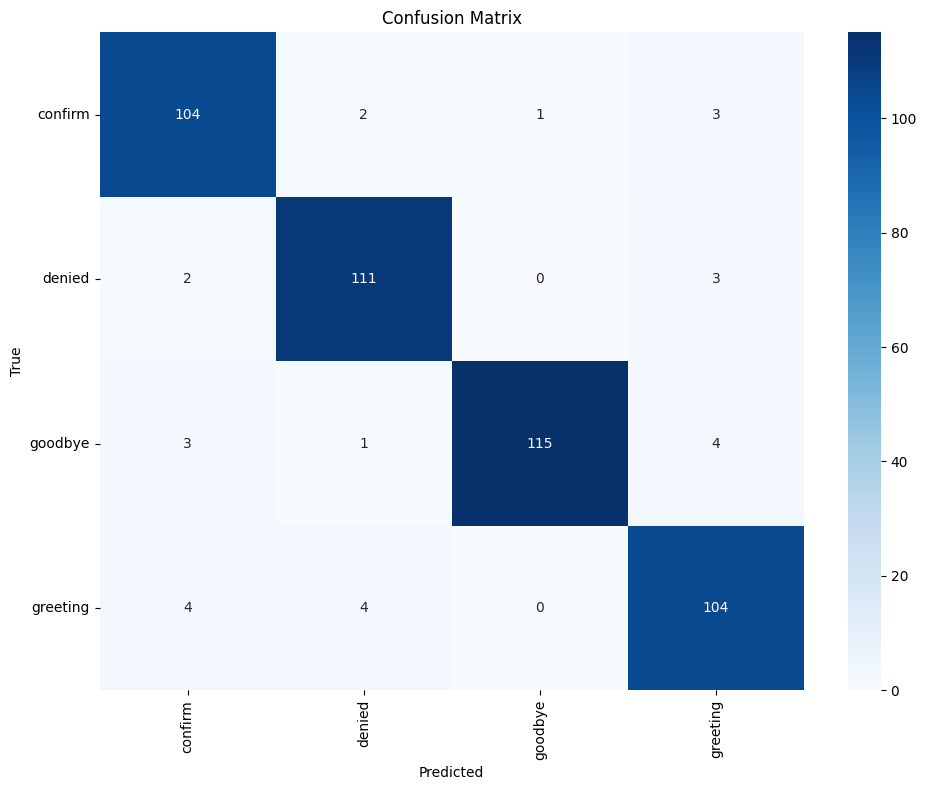


✅ Model telah berhasil dilatih dan disimpan di /content/drive/MyDrive/indobert_intent_model2
Jumlah intent: 4
Intent yang didukung: confirm, denied, goodbye, greeting


In [14]:
# Cell 13: Jalankan pipeline (uncomment untuk menjalankan)

model, tokenizer, intent_classes, label_encoder = run_full_pipeline()


# Cell 14: Jalankan demo prediksi (uncomment untuk menjalankan)


In [ ]:

run_prediction_demo(model, tokenizer, intent_classes, label_encoder)


OOD threshold loaded: -4.0359
Demo Prediksi Intent dengan OOD Detection:

Input: "Halo!"
Intent terdeteksi: greeting (confidence: 0.9993)
Top 3 intent:
  1. greeting: 0.9993
  2. goodbye: 0.0004
  3. confirm: 0.0002

Input: "Oke, sampai jumpa!"
Intent terdeteksi: goodbye (confidence: 0.9994)
Top 3 intent:
  1. goodbye: 0.9994
  2. confirm: 0.0003
  3. greeting: 0.0002

Input: "Ya, benar begitu."
Intent terdeteksi: confirm (confidence: 0.9985)
Top 3 intent:
  1. confirm: 0.9985
  2. goodbye: 0.0008
  3. denied: 0.0006

Input: "Tidak, saya tidak setuju."
Intent terdeteksi: denied (confidence: 0.9992)
Top 3 intent:
  1. denied: 0.9992
  2. confirm: 0.0005
  3. goodbye: 0.0002

Input: "Halo, saya ingin memesan tiket ke Bali."
Intent terdeteksi: greeting (confidence: 0.9992)
Top 3 intent:
  1. greeting: 0.9992
  2. confirm: 0.0004
  3. goodbye: 0.0003

Input: "Sampai jumpa... Eh, tunggu sebentar, ada yang ingin saya tanyakan!"
Intent terdeteksi: goodbye (confidence: 0.9986)
Top 3 intent:
  

In [3]:
import pandas as pd
import random
import nltk
from deep_translator import GoogleTranslator
from nltk.corpus import wordnet
from collections import defaultdict
import os

nltk.download('omw-1.4')
nltk.download('wordnet')

# Load dataset
file_path = "/content/aaaa.xlsx"  # Ganti dengan path file XLSX
csv_path = file_path.replace(".xlsx", ".csv")  # Buat path CSV

# Konversi XLSX ke CSV jika diperlukan
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path)
    df.to_csv(csv_path, index=False)
    print(f"✅ File dikonversi ke CSV: {csv_path}")
else:
    df = pd.read_csv(file_path)

# Fungsi mendapatkan sinonim dari WordNet
def get_synonym(word):
    synonyms = set()
    for syn in wordnet.synsets(word, lang='ind'):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Fungsi mengganti kata dengan sinonim
def replace_with_synonym(sentence):
    words = sentence.split()
    new_words = [random.choice(get_synonym(word)) if get_synonym(word) else word for word in words]
    return " ".join(new_words)

# Fungsi backtranslation
def back_translate(sentence):
    translated = GoogleTranslator(source='id', target='en').translate(sentence)
    return GoogleTranslator(source='en', target='id').translate(translated)

# Fungsi menambahkan typo
def add_typo(sentence):
    chars = list(sentence)
    if len(chars) > 3:
        idx = random.randint(0, len(chars) - 1)
        chars[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)

# Fungsi random deletion
def random_deletion(sentence, p=0.3):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.uniform(0, 1) > p]
    return " ".join(new_words) if new_words else random.choice(words)

# Fungsi random swap
def random_swap(sentence, n=1):
    words = sentence.split()
    if len(words) < 2:
        return sentence
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return " ".join(words)

# Fungsi phonetic augmentation
def phonetic_augmentation(sentence):
    phonetic_dict = {
        "saya": "sy", "kamu": "km", "oke": "ok", "ga": "g", "ya": "y",
        "dong": "dongz", "bro": "brow", "please": "plis", "bisa": "bs", "selamat": "slmt"
    }
    words = sentence.split()
    new_words = [phonetic_dict[word] if word in phonetic_dict else word for word in words]
    return " ".join(new_words)

# Fungsi menambahkan kata atau frasa umum
def add_common_phrase(sentence):
    common_phrases = ["ya", "anjay", "dong", "cuy", "bro", "lah", "plis", "eh"]
    return sentence + " " + random.choice(common_phrases)

# Fungsi augmentasi data
def augment_data(text):
    augmented_texts = [
        text,
        replace_with_synonym(text),
        back_translate(text),
        add_typo(text),
        random_deletion(text),
        random_swap(text),
        phonetic_augmentation(text),
        add_common_phrase(text)
    ]
    return list(set(augmented_texts))  # Hindari duplikasi

# Proses augmentasi
df_augmented = []
for _, row in df.iterrows():
    texts = augment_data(row['text'])
    for new_text in texts:
        df_augmented.append([new_text, row['intent']])

df_augmented = pd.DataFrame(df_augmented, columns=["text", "intent"])
output_path = "/content/sample_intent_data.csv"
df_augmented.to_csv(output_path, index=False)

# Statistik Augmentasi
print("✅ Augmentasi selesai! Dataset baru tersimpan sebagai 'sample_intent_data.csv'.")
print(f"📌 Jumlah data sebelum augmentasi: {len(df)}")
print(f"📌 Jumlah data setelah augmentasi: {len(df_augmented)}")


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


✅ File dikonversi ke CSV: /content/aaaa.csv
✅ Augmentasi selesai! Dataset baru tersimpan sebagai 'sample_intent_data.csv'.
📌 Jumlah data sebelum augmentasi: 400
📌 Jumlah data setelah augmentasi: 2301


In [ ]:
!pip install deep-translator


In [ ]:
# prompt: the model already trained and saved to drive, but can i test the model without running thee training.

# Path ke folder model di Google Drive
model_path = "/content/drive/MyDrive/indobert_intent_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load intent classes
with open(f"{model_path}/intent_classes.pkl", "rb") as f:
    intent_classes = pickle.load(f)

# Load label encoder (jika diperlukan)
with open(f"{model_path}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


def predict_intent(text, model, tokenizer, intent_classes, device=None):
    """Memprediksi intent dari teks input"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    predicted_intent = intent_classes[prediction]

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    return predicted_intent, confidence, topk_intents


# Contoh penggunaan
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        intent, confidence, topk = predict_intent(user_input, model, tokenizer, intent_classes)
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")



In [ ]:
# prompt: xlsx to csv convert

import pandas as pd

# Replace 'input.xlsx' with the actual path to your Excel file
excel_file = 'input.xlsx'

# Replace 'output.csv' with the desired path and name for your CSV file
csv_file = 'output.csv'

try:
  # Read the Excel file into a Pandas DataFrame
  df = pd.read_excel(excel_file)

  # Convert the DataFrame to a CSV file
  df.to_csv(csv_file, index=False)

  print(f"Successfully converted '{excel_file}' to '{csv_file}'")

except FileNotFoundError:
  print(f"Error: File '{excel_file}' not found.")
except Exception as e:
  print(f"An error occurred: {e}")


In [ ]:
!git status


On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	rusdi-prototype-1/

nothing added to commit but untracked files present (use "git add" to track)
